# Fine tuning the transfer learning models

- Mobile v3, ideal to run on edge device
- 10 monkey datasets

## Imports 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


import torchvision
from torchvision import models, transforms, datasets
from torchvision.ops import Conv2dNormActivation

from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import os
import time
from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from tqdm import tqdm


from PIL import Image
import random

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')


In [7]:
# random number generator

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seed(42)

## Download the dataset

In [9]:
# we already downloaded it for another notebook
data_dir = '10_Monkey_species'

## Dataset and training configuration params

### config

In [14]:
@dataclass(frozen=True) # params are immutable
class TrainingConfig:
    batch_size: int = 32
    epochs: int = 20
    learning_rate: float = 1e-4
    device: str = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    log_interval: int = 1
    test_interval: int = 1
    data_root: str = data_dir
    num_workers: int = 5

    def __post_init__(self):
        print("DEVICE USED: ",self.device)

train_config = TrainingConfig()

DEVICE USED:  cuda


### class labels

In [25]:
# class labels:
df = pd.read_csv(os.path.join(data_dir, 'monkey_labels.txt'))
df.columns = ['Label', 'LatinName', 'CommonName', 'TrainImages', 'ValidationImages']
class_labels = df['CommonName'].str.replace(' ', '')
print(class_labels)

0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: CommonName, dtype: object


In [26]:
train_root = os.path.join(train_config.data_root, 'training', 'training')
val_root = os.path.join(train_config.data_root, 'validation', 'validation')
print(train_root)
print(val_root)

10_Monkey_species\training\training
10_Monkey_species\validation\validation


## Dataset Preprocessing

In [28]:
mean = [0.4368, 0.4336, 0.3294]
std = [0.2457, 0.2413, 0.2447]

img_size = (224, 224)

preprocess = transforms.Compose([
    transforms.Resize(img_size, antialias=True),
    transforms.ToTensor(),
])

common_transforms = transforms.Compose([
    preprocess,
    transforms.Normalize(mean, std)
])

train_transforms = transforms.Compose([
    preprocess,
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(p = 0.4), # random erasing for data augmentation 

    # random affine transformation
    transforms.RandomApply([transforms.RandomAffine(degrees=(30,70), translate=(0.1, 0.3), scale=(0.5, 0.75))],
                           p = 0.1), # apply 10 % of the time

    transforms.Normalize(mean, std)
])

### Data loader

In [33]:
train_data = datasets.ImageFolder(train_root, transform=train_transforms)
val_data = datasets.ImageFolder(val_root, transform=common_transforms)
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [34]:
train_loader = DataLoader(train_data, batch_size=train_config.batch_size, shuffle=True, num_workers=train_config.num_workers)
val_loader = DataLoader(val_data, batch_size=train_config.batch_size, shuffle=False, num_workers=train_config.num_workers)

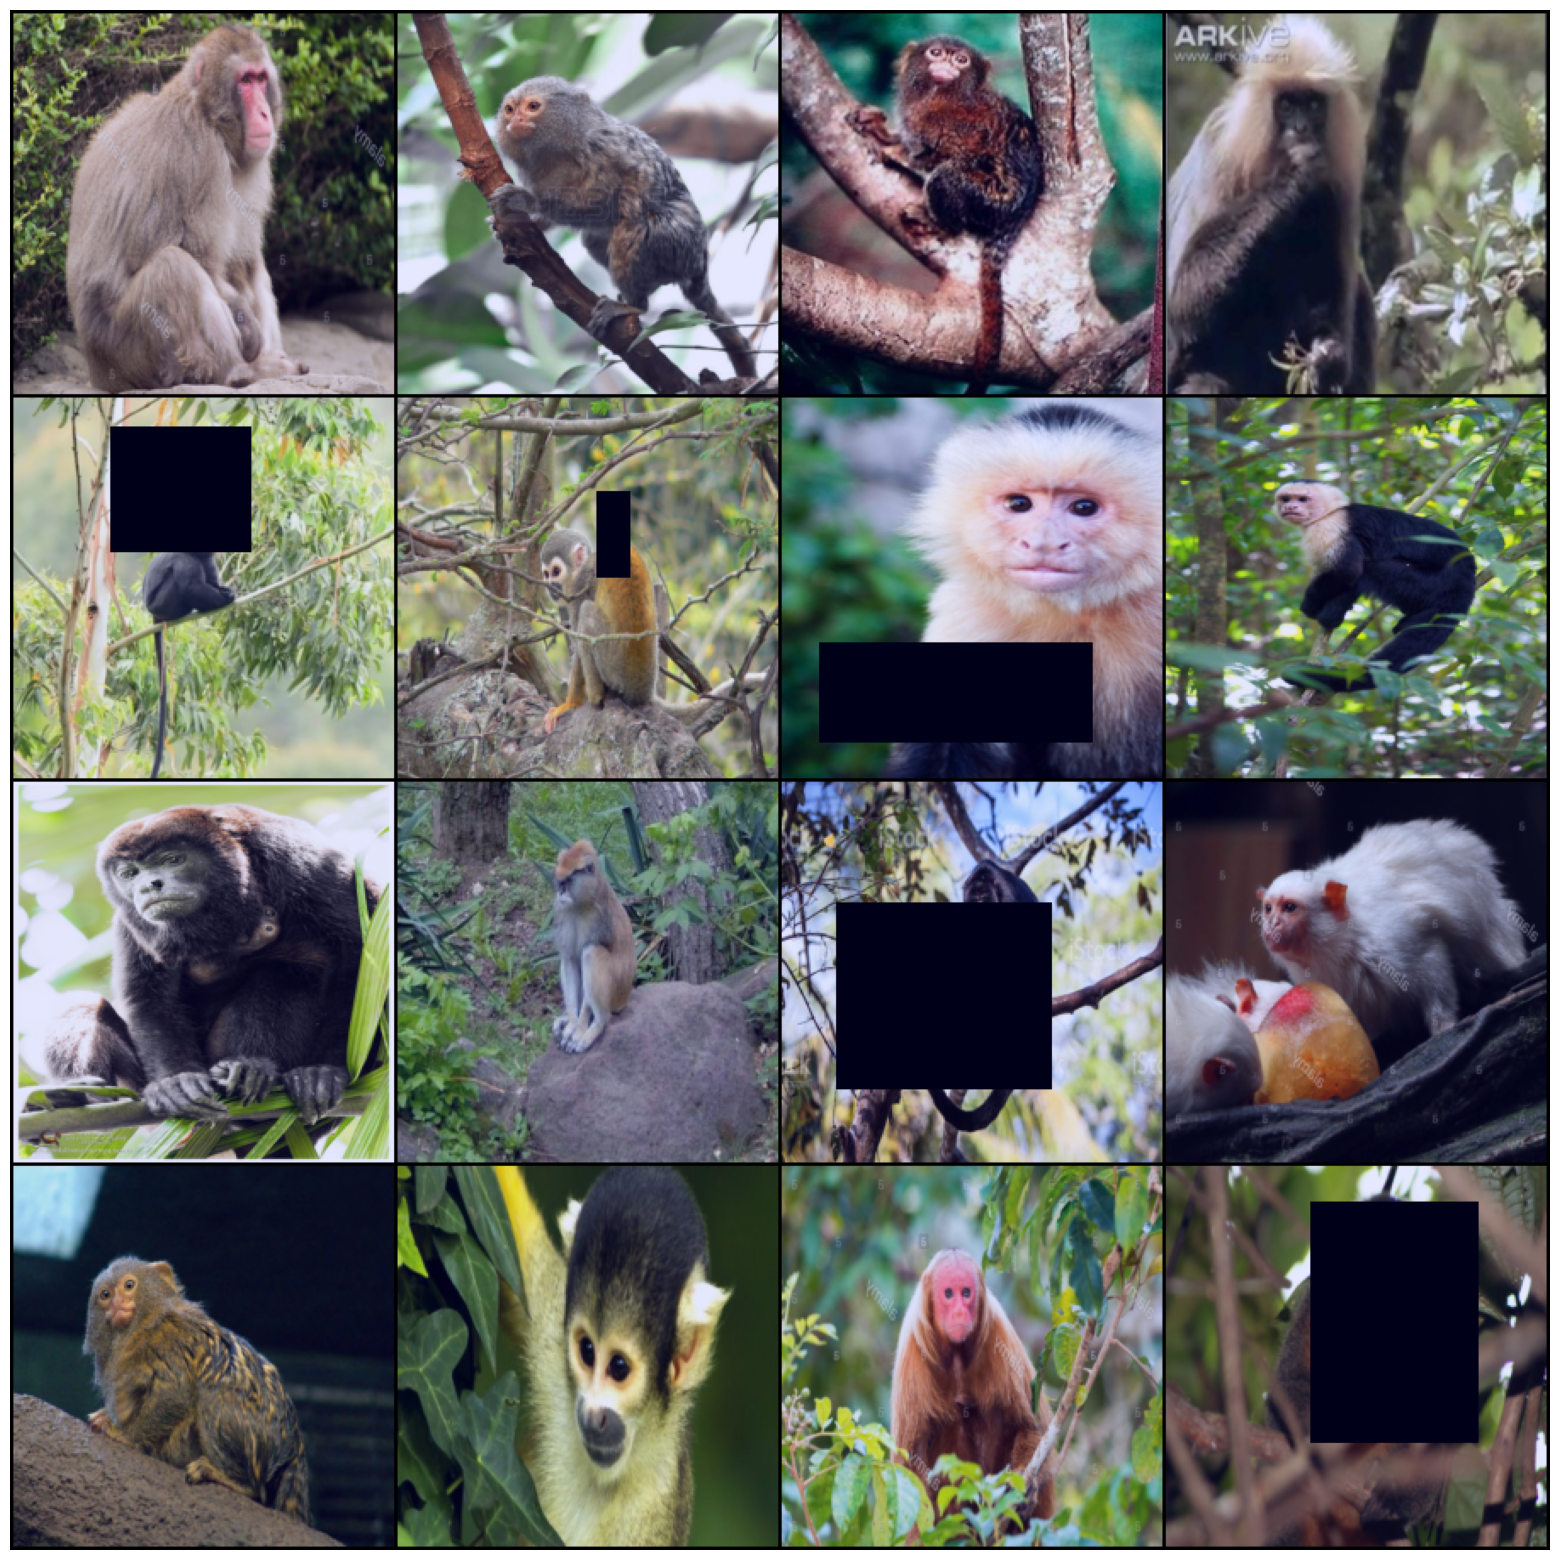

In [38]:
# display the train images to see the data augmentation
def display_images(loader, n_images):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    grid_image = torchvision.utils.make_grid(images[:n_images], nrow=4, padding=2, normalize=True)
    fig = plt.figure(figsize=(20, 20))
    plt.imshow(grid_image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

display_images(train_loader, 16)
    

### Pretrained model

In [42]:
mnv3 = models.mobilenet_v3_small(weights='DEFAULT')
# for this model, it has been created in such a way the layers are named as features and classifier
# number of feature layer
num_ftrs = len(mnv3.features)
print('Number of feature layers: ', num_ftrs)

# numbe of classifier layers
num_cls = len(mnv3.classifier)
print('Number of classifier layers: ', num_cls)

Number of feature layers:  13
Number of classifier layers:  4


In [41]:
mnv3.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [43]:
# freeze layers to prevent backpropagation
for param in mnv3.features[:10].parameters(): # freeze the first 10 layers
    param.requires_grad = False

(classifier): Sequential(
    (0): Linear(in_features=576, out_features=1024, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.2, inplace=True)
    (3): Linear(in_features=1024, out_features=1000, bias=True)

In [45]:
mnv3.classifier[3] = nn.Linear(1024, len(class_labels)) # change the output layer to 10 classes
model = mnv3

### Optimizers and loggers

In [47]:
optimizer = optim.Adam(model.parameters(), lr=train_config.learning_rate)

logdir = "logs/mnv3_small_monkeys"

writer = SummaryWriter(logdir)  

# print summary of the model
summary(model, input_size=(train_config.batch_size, 3, 224, 224), row_settings=['var_names'])

Layer (type (var_name))                                      Output Shape              Param #
MobileNetV3 (MobileNetV3)                                    [32, 10]                  --
├─Sequential (features)                                      [32, 576, 7, 7]           --
│    └─Conv2dNormActivation (0)                              [32, 16, 112, 112]        --
│    │    └─Conv2d (0)                                       [32, 16, 112, 112]        (432)
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]        (32)
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]        --
│    └─InvertedResidual (1)                                  [32, 16, 56, 56]          --
│    │    └─Sequential (block)                               [32, 16, 56, 56]          (744)
│    └─InvertedResidual (2)                                  [32, 24, 28, 28]          --
│    │    └─Sequential (block)                               [32, 24, 28, 28]          

## Model training

### train func

In [65]:
def train(model, train_loader, optimizer, device):
    model.train()
    model.to(device)

    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

        _, predicted = torch.max(outputs.detach(), dim = 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_loss = running_loss / total_preds
    train_accuracy = 100 * correct_preds / total_preds

    return train_loss, train_accuracy

### Val func

In [66]:
def validation(model, val_loader, device):
    model.eval()
    model.to(device)

    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)

            running_loss += loss.item() * labels.size(0)

            _, predicted = torch.max(outputs.detach(), dim = 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    val_loss = running_loss / total_preds
    val_accuracy = 100 * correct_preds / total_preds

    return val_loss, val_accuracy

### Main func

In [67]:
def main(model, train_loader, val_loader, epochs, optimizer, device, writer):
    best_val_accuracy = 0.0
    best_model = None

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, device)
        val_loss, val_accuracy = validation(model, val_loader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'mnv3_small_monkeys.pth')

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    return train_losses, train_accuracies, val_losses, val_accuracies

In [68]:
train_loss, train_accuracy, val_loss, val_accuracy = main(model, train_loader, val_loader, train_config.epochs, optimizer, train_config.device, writer)

Validation: 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Epoch 1/20, Train Loss: 0.1426, Train Accuracy: 95.26%, Val Loss: 0.0949, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 2/20, Train Loss: 0.1380, Train Accuracy: 95.62%, Val Loss: 0.1036, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 3/20, Train Loss: 0.1410, Train Accuracy: 95.44%, Val Loss: 0.1001, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


Epoch 4/20, Train Loss: 0.1274, Train Accuracy: 95.44%, Val Loss: 0.1145, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Epoch 5/20, Train Loss: 0.1156, Train Accuracy: 96.44%, Val Loss: 0.0979, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]


Epoch 6/20, Train Loss: 0.1208, Train Accuracy: 95.72%, Val Loss: 0.0988, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


Epoch 7/20, Train Loss: 0.1198, Train Accuracy: 96.17%, Val Loss: 0.0955, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 8/20, Train Loss: 0.1092, Train Accuracy: 95.72%, Val Loss: 0.0889, Val Accuracy: 97.43%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 9/20, Train Loss: 0.1402, Train Accuracy: 95.81%, Val Loss: 0.0975, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 10/20, Train Loss: 0.1386, Train Accuracy: 95.26%, Val Loss: 0.0876, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 11/20, Train Loss: 0.1091, Train Accuracy: 96.54%, Val Loss: 0.0941, Val Accuracy: 97.43%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 12/20, Train Loss: 0.0877, Train Accuracy: 97.63%, Val Loss: 0.0881, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]


Epoch 13/20, Train Loss: 0.0999, Train Accuracy: 97.08%, Val Loss: 0.0847, Val Accuracy: 97.43%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Epoch 14/20, Train Loss: 0.1007, Train Accuracy: 96.90%, Val Loss: 0.0792, Val Accuracy: 97.43%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


Epoch 15/20, Train Loss: 0.0890, Train Accuracy: 96.99%, Val Loss: 0.0796, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 16/20, Train Loss: 0.1108, Train Accuracy: 96.26%, Val Loss: 0.0809, Val Accuracy: 97.43%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 17/20, Train Loss: 0.0960, Train Accuracy: 96.99%, Val Loss: 0.0777, Val Accuracy: 97.43%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 18/20, Train Loss: 0.0979, Train Accuracy: 96.44%, Val Loss: 0.0752, Val Accuracy: 97.43%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 19/20, Train Loss: 0.0785, Train Accuracy: 97.36%, Val Loss: 0.0752, Val Accuracy: 97.79%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]

Epoch 20/20, Train Loss: 0.0929, Train Accuracy: 97.17%, Val Loss: 0.0732, Val Accuracy: 97.43%


### Plot loss and Accuracies

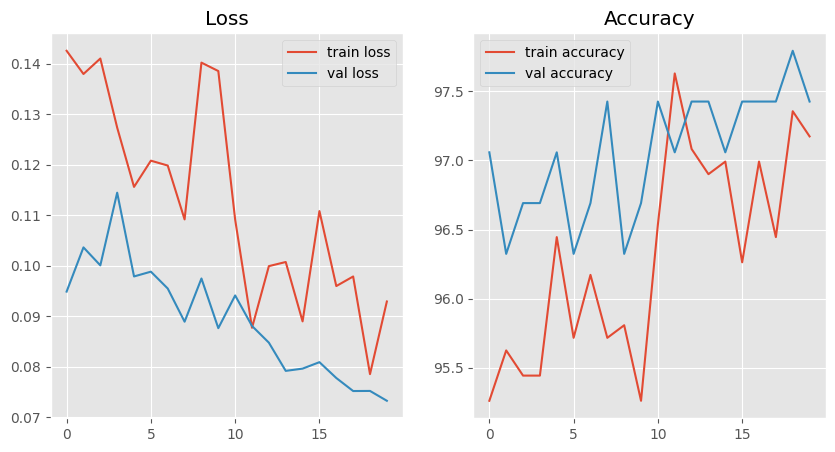

In [70]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='train accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

## Loading the model

In [71]:
model.load_state_dict(torch.load('mnv3_small_monkeys.pth'))

<All keys matched successfully>

### Inference

In [88]:
def prediction(model, loader, device):
    model.eval()
    model.to(device)

    all_images, all_labels = [], []
    all_pred_indices, all_pred_prob = [], []

    with torch.inference_mode():
        for images, labels in tqdm(loader, desc='Predicting'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            prob_cls, index = torch.max(probs, dim = 1)
           


            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_pred_indices.append(index.cpu())
            all_pred_prob.append(prob_cls.cpu())

    return (
        torch.cat(all_images).numpy(),
        torch.cat(all_labels).numpy(),
        torch.cat(all_pred_indices).numpy(),
        torch.cat(all_pred_prob).numpy()
    )


In [89]:
# denormalize the image
def denormlaize(image):

    mean_arr = np.array(mean)
    std_arr = np.array(std)
    denorm_image = image* std_arr + mean_arr
    denorm_image = np.clip(denorm_image, 0, 1)
    return denorm_image

In [92]:
def visualize_predictions(sample_images, gt_label, pred_indices, pred_prob, num_of_images= 5):
    fig = plt.figure(figsize=(20, 5))

    for i in range(num_of_images):
        idx = random.randint(0, len(sample_images)-1)
        image = sample_images[idx].transpose(1, 2, 0)
        image = denormlaize(image)
        gt = gt_label[idx]
        pred = pred_indices[idx]
        prob = pred_prob[idx]

        ax = fig.add_subplot(1, num_of_images, i+1)
        ax.imshow(image)
        ax.set_title(f'GT: {class_labels[gt]}\nPred: {class_labels[pred]}\nProb: {prob:.2f}')
        ax.axis('off')

    plt.show()  

Predicting: 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


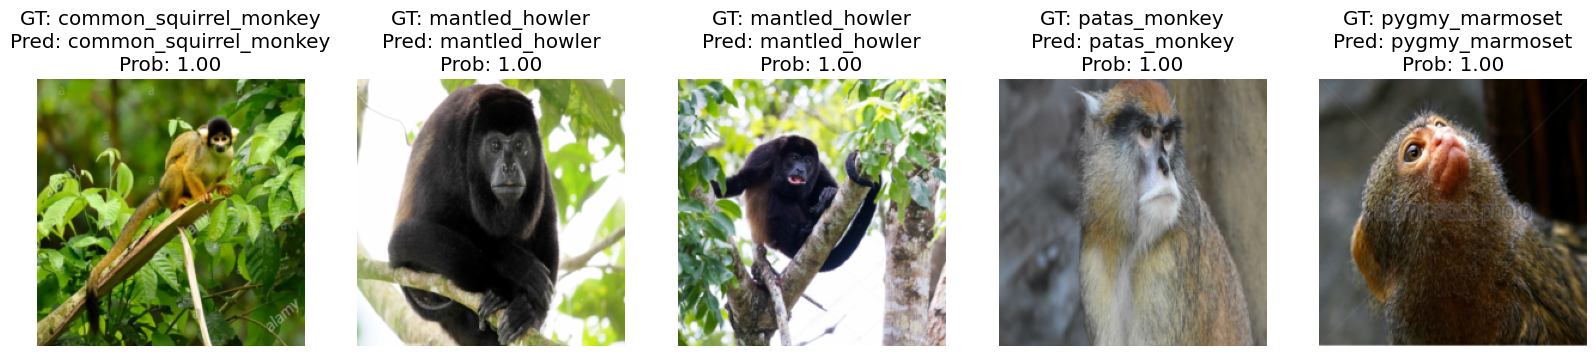

In [93]:
val_images, val_labels, pred_indices, pred_prob = prediction(model, val_loader, train_config.device)
visualize_predictions(val_images, val_labels, pred_indices, pred_prob, 5)

### confusion matrix

<Axes: >

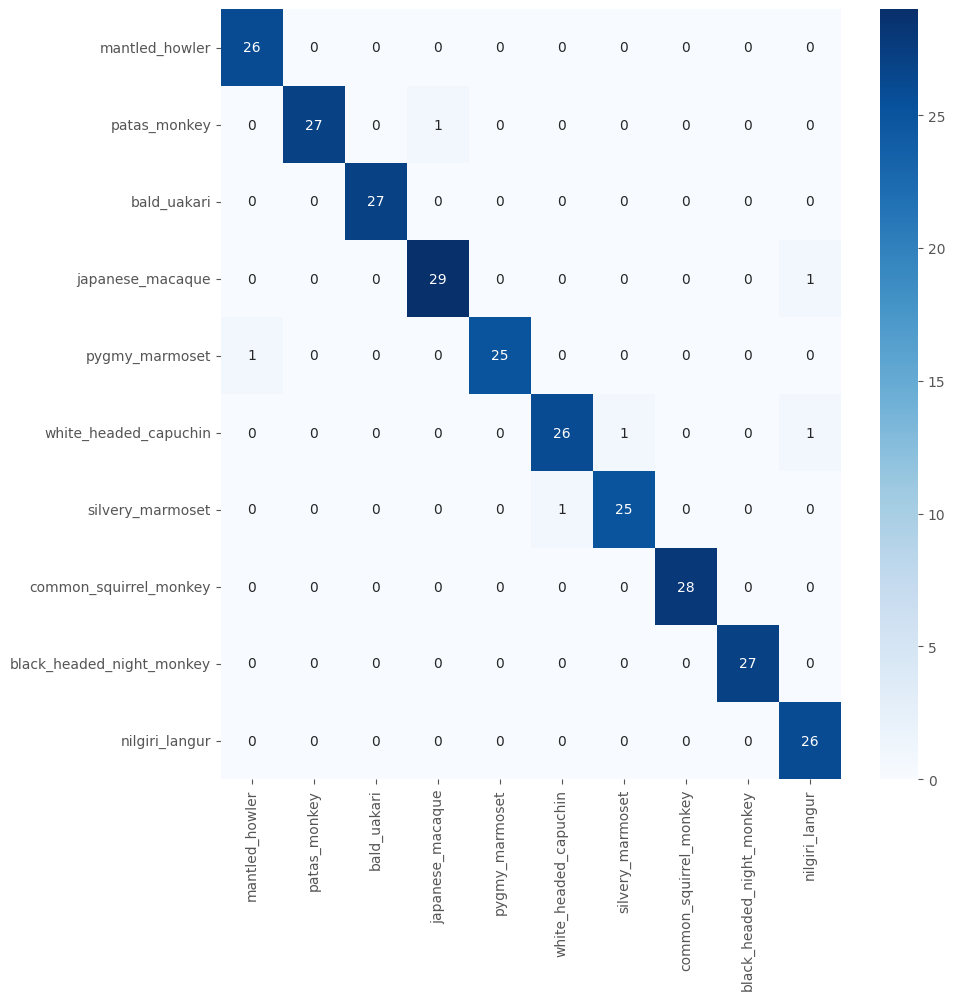

In [94]:
cm = confusion_matrix(val_labels, pred_indices)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')